# 7th Factory Work Activity Recognition Challenge

This notebook has been designed for the 7th Factory Work Activity Recognition Challenge competition with the aim of Activity Recognition using REAL Accelerometer from OpenPack dataset and GENERATED Accelerometer created by subjects.

If you have any questions, please feel free to email abc2025@sozolab.jp with the subject 7th Factory Work Activity Recognition Challenge.

About this dataset and challenge -> https://abc-research.github.io/challenge2025/

This notebook was prepared by Qingxin Xia.

# Mount Drive

This tutorial is made in Google Colab. So, first we need to connect the Google Drive to access the data. You can directly add folder path to access the data.

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load Necessary Libraries

In [247]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
# from transforms3d.axangles import axangle2mat  # for rotation
from scipy.interpolate import CubicSpline  # for warping
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

In [241]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


# Prepare data

https://github.com/open-pack/openpack-dataset/blob/main/docs/DOWNLOAD.md

## Create Folders

Firstly, a folder is created to save OpenPack dataset: '/data/real/'.

Subjects are required to download OpenPack dataset by themselves. The data should be placed at: '/data/real/'.

Another folder '/data/virtual/' will be created to save generated data.
 *(Pay attention, the size of this folder is limited to TBD.)*

In [144]:
realpath = r'\data\real'

# Create the directory
os.makedirs(realpath, exist_ok=True)

print(f"Directory '{realpath}' created successfully.")

virtpath = r'\data\virtual'

# Create the directory
os.makedirs(virtpath, exist_ok=True)

print(f"Directory '{virtpath}' created successfully.")

rootdir = r'D:\code\OpenPackChallenge2025'  # replace with your project path
real_directory = rootdir + realpath  
virt_directory = rootdir + virtpath  
# directory = r'D:\code\OpenPackChallenge2025\data\real'  


Directory '\data\real' created successfully.
Directory '\data\virtual' created successfully.


## Unzip OpenPack dataset

After placing the OpenPack dataset at the '/data/real/' folder, unzip the files and delete the zip files.

In [65]:
# Iterate over all files in the directory
for filename in os.listdir(real_directory):
    # Construct full file path
    file_path = os.path.join(real_directory, filename)
    
    # Check if the file is a zip file
    if filename.endswith('.zip'):
        # Open the zip file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zip file into the directory
            zip_ref.extractall(file_path[:-4])
            print(f"Extracted: {filename}")
        
        # Delete the zip file
        os.remove(file_path)
        print(f"Deleted: {filename}")

print("All zip files have been processed.")

Extracted: imu-with-operation-action-labels.zip
Deleted: imu-with-operation-action-labels.zip
All zip files have been processed.


# Use Real Data to Generate Virtual Data

First, we will randomly split the real data into a training set, validation set, and test set according to a certain ratio. Then, we will use the training set data to generate virtual data. Finally, we will train the network using the training set and virtual data, and calculate the F1 score on the test set.

The following code is an example. Note: (1) The model structure is fixed and unchanged. (2) The split ratio for the training and test sets and the random seed will not be disclosed. (3) Subjects are free to design data generation algorithms and save them to a specified path: '/data/virtual/'.

## Assign train users, validation users, and test users

In the OpenPack dataset, U0xxx corresponds to user IDs, and S0xxx corresponds to different experiment settings.

In this Challenge, we will only select training (real) and test data from S0100.

### Filter out un-used data

In [74]:
user_paths = {}
for root, dirs, files in os.walk(real_directory):
    for file in files:
        if file.endswith('S0100.csv'):
            user_paths[file[:-10]] = os.path.join(root, file)
for u, d in user_paths.items():
    print('%s at: %s'% (u,d))

U0101 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0101-S0100.csv
U0102 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0102-S0100.csv
U0103 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0103-S0100.csv
U0104 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0104-S0100.csv
U0105 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0105-S0100.csv
U0106 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0106-S0100.csv
U0107 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-labels\imu-with-operation-action-labels\U0107-S0100.csv
U0108 at: D:\code\OpenPackChallenge2025\data\real\imu-with-operation-action-

### Split users to train, validation, and test sets

In [80]:
userIDs = list(user_paths.keys())

# Shuffle the list to ensure randomness
random.shuffle(userIDs)

# Calculate the split indices
total_length = len(userIDs)
train_size = int(total_length * 0.7)  # 70% of 10
val_size = int(total_length * 0.1)  # 10% of 10
test_size = total_length - train_size - val_size  # 20% of 10

# Split the list according to the calculated sizes
train_users = np.sort(userIDs[:train_size])      # First 70%
val_users = np.sort(userIDs[train_size:train_size + val_size])  # Next 10%
test_users = np.sort(userIDs[train_size + val_size:])  # Last 20%

print('Training set: %s'%train_users)
print('Validation set: %s'%val_users)
print('Test set: %s'%test_users)


Training set: ['U0103' 'U0104' 'U0105' 'U0106' 'U0107' 'U0109' 'U0110' 'U0201' 'U0203'
 'U0204' 'U0206' 'U0208' 'U0209' 'U0210']
Validation set: ['U0102' 'U0202']
Test set: ['U0101' 'U0108' 'U0111' 'U0205' 'U0207']


## Load data according to userIDs

Load data of every user as dataframe.
Use acceleration data of both wrists only;
Use operation label.

In [86]:
selected_columns = ['atr01/acc_x','atr01/acc_y','atr01/acc_z','atr02/acc_x','atr02/acc_y','atr02/acc_z','timestamp','operation'] 
train_data_dict = {}
for u in train_users:
    # Load the CSV file with only the selected columns
    train_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)

val_data_dict = {}
for u in val_users:
    # Load the CSV file with only the selected columns
    val_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)
    
test_data_dict = {}
for u in test_users:
    # Load the CSV file with only the selected columns
    test_data_dict[u] = pd.read_csv(user_paths[u], usecols=selected_columns)

### show an example of data

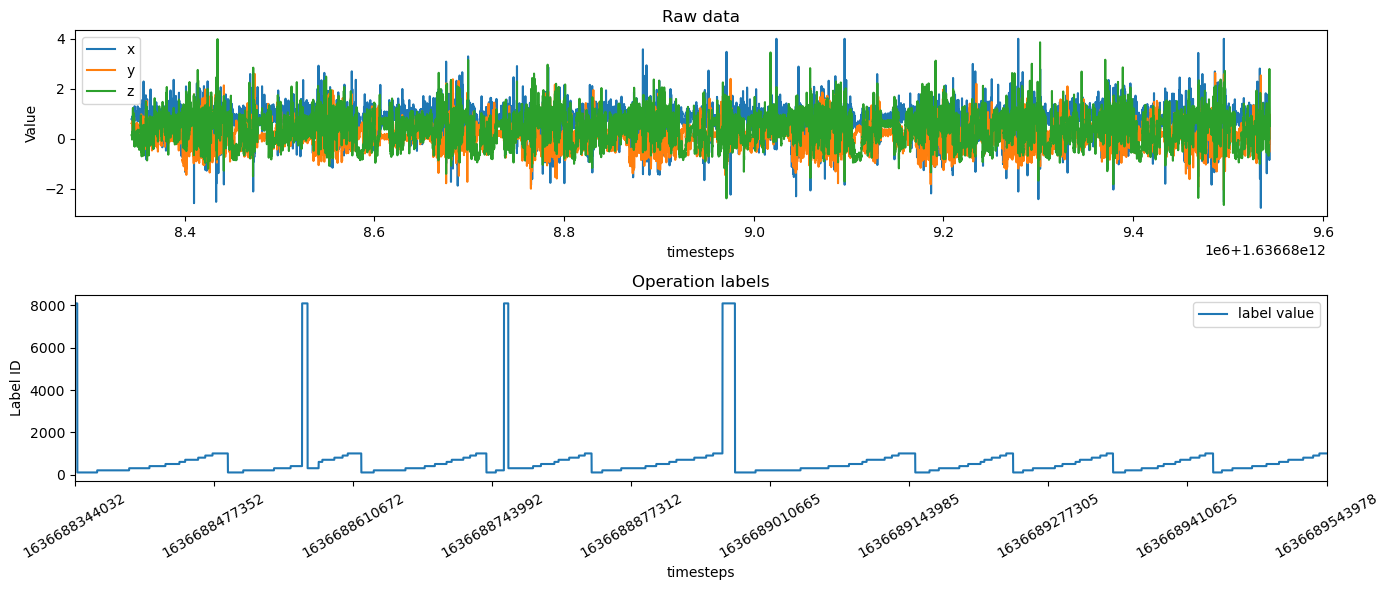

In [124]:
df = train_data_dict[train_users[0]]

n = 10  # only show n timestamps on fig
# timezone_jst = datetime.timezone(datetime.timedelta(hours=9))
# dates = [str(datetime.datetime.fromtimestamp(ts / 1000).replace(tzinfo=timezone_jst)) for ts in df['timestamp'].values]
dates = df.timestamp.values
# Select n equally spaced indices to show on the x-axis
indices = np.linspace(0, len(dates) - 1, n, dtype=int)
selected_dates = [dates[i] for i in indices]

data = df[['atr01/acc_x','atr01/acc_y','atr01/acc_z']].values

l = df['operation'].values

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
# First subplot
axs[0].plot(dates, data[:,0], label='x') 
axs[0].plot(dates, data[:,1], label='y') 
axs[0].plot(dates, data[:,2], label='z') 
axs[0].set_title('Raw data')
axs[0].set_xlabel('timesteps')
axs[0].set_ylabel('Value')
axs[0].legend()
# Set x-ticks for the current subplot
# axs[0].set_xticks(selected_dates)
# axs[0].set_xticklabels(selected_dates, rotation=60)  # Set labels and rotate
# axs[0].set_xlim([dates[0], dates[-1]])  # Set x-axis limits
# axs[0].grid()

# Second subplot
axs[1].plot(dates, l, label='label value') 
axs[1].set_title('Operation labels')
axs[1].set_xlabel('timesteps')
axs[1].set_ylabel('Label ID')
axs[1].set_xticks(selected_dates)
axs[1].set_xticklabels(selected_dates, rotation=30)  # Set labels and rotate
axs[1].set_xlim([dates[0], dates[-1]])  # Set x-axis limits
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

## Example of Virtual Data Generation

Here, we use data augmentations to generate new data.

In [58]:
"""
This code implements a list of transforms for tri-axial raw-accelerometry
We assume that the input format is of size:
3 x (epoch_len * sampling_frequency)

Transformations included:
1. jitter
2. Channel shuffling: which axis is being switched
3. Horizontal flip: binary
4. Permutation: binary

This script is mostly based off from
https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.py
"""

def switch_axis(sample, choice):
    """
    Randomly switch the three axises for the raw files

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-6 for direction selection
    """
    x = sample[0, :]
    y = sample[1, :]
    z = sample[2, :]

    if choice == 0:
        return sample
    elif choice == 1:
        sample = np.stack([x, y, z], axis=0)
    elif choice == 2:
        sample = np.stack([x, z, y], axis=0)
    elif choice == 3:
        sample = np.stack([y, x, z], axis=0)
    elif choice == 4:
        sample = np.stack([y, z, x], axis=0)
    elif choice == 5:
        sample = np.stack([z, x, y], axis=0)
    elif choice == 6:
        sample = np.stack([z, y, x], axis=0)
    return sample


def flip(sample, choice):
    """
    Flip over the actigram on the temporal scale

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-1 binary
    """
    if choice == 1:
        sample = np.flip(sample, 1)
    return sample


def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile is True:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(
            np.random.randint(
                minSegLength, X.shape[0] - minSegLength, nPerm - 1
            )
        )
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]] : segs[idx[ii] + 1], :]
        X_new[pp : pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


def permute(sample, choice, nPerm=4, minSegLength=10):
    """
    Distort an epoch by dividing up the sample into several segments and
    then permute them

    Args:
        sample (numpy array): 3 * FEATURE_SIZE
        choice (int): 0-1 binary
    """
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_Permutation(sample, nPerm=nPerm, minSegLength=minSegLength)
        sample = np.swapaxes(sample, 0, 1)
    return sample


def is_scaling_factor_invalid(scaling_factor, min_scale_sigma):
    """
    Ensure each of the abs values of the scaling
    factors are greater than the min
    """
    for i in range(len(scaling_factor)):
        if abs(scaling_factor[i] - 1) < min_scale_sigma:
            return True
    return False


def DA_Scaling(X, sigma=0.3, min_scale_sigma=0.05):
    scaling_factor = np.random.normal(
        loc=1.0, scale=sigma, size=(1, X.shape[1])
    )  # shape=(1,3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_sigma):
        scaling_factor = np.random.normal(
            loc=1.0, scale=sigma, size=(1, X.shape[1])
        )
    my_noise = np.matmul(np.ones((X.shape[0], 1)), scaling_factor)
    X = X * my_noise
    return X


def scaling_uniform(X, scale_range=0.15, min_scale_diff=0.02):
    low = 1 - scale_range
    high = 1 + scale_range
    scaling_factor = np.random.uniform(
        low=low, high=high, size=(X.shape[1])
    )  # shape=(3)
    while is_scaling_factor_invalid(scaling_factor, min_scale_diff):
        scaling_factor = np.random.uniform(
            low=low, high=high, size=(X.shape[1])
        )

    for i in range(3):
        X[:, i] = X[:, i] * scaling_factor[i]

    return X


def scale(sample, choice, scale_range=0.5, min_scale_diff=0.15):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = scaling_uniform(
            sample, scale_range=scale_range, min_scale_diff=min_scale_diff
        )
        sample = np.swapaxes(sample, 0, 1)
    return sample


def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(
        X, sigma
    )  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [
        (X.shape[0] - 1) / tt_cum[-1, 0],
        (X.shape[0] - 1) / tt_cum[-1, 1],
        (X.shape[0] - 1) / tt_cum[-1, 2],
    ]
    tt_cum[:, 0] = tt_cum[:, 0] * t_scale[0]
    tt_cum[:, 1] = tt_cum[:, 1] * t_scale[1]
    tt_cum[:, 2] = tt_cum[:, 2] * t_scale[2]
    return tt_cum


def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (
        np.ones((X.shape[1], 1))
        * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))
    ).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:, 0], yy[:, 0])
    cs_y = CubicSpline(xx[:, 1], yy[:, 1])
    cs_z = CubicSpline(xx[:, 2], yy[:, 2])
    return np.array([cs_x(x_range), cs_y(x_range), cs_z(x_range)]).transpose()


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:, 0] = np.interp(x_range, tt_new[:, 0], X[:, 0])
    X_new[:, 1] = np.interp(x_range, tt_new[:, 1], X[:, 1])
    X_new[:, 2] = np.interp(x_range, tt_new[:, 2], X[:, 2])
    return X_new


def time_warp(sample, choice, sigma=0.2):
    if choice == 1:
        sample = np.swapaxes(sample, 0, 1)
        sample = DA_TimeWarp(sample, sigma=sigma)
        sample = np.swapaxes(sample, 0, 1)
    return sample

### Example of data augmentation

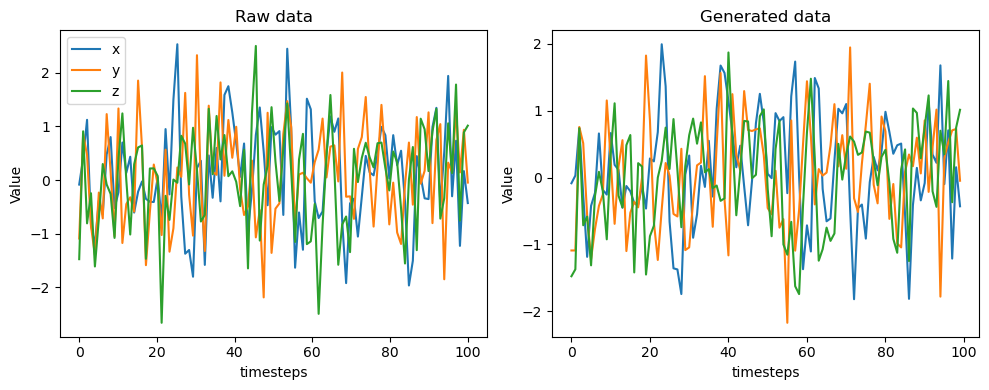

In [64]:
random_array_normal = np.random.randn(3, 100)
warped_data = time_warp(random_array_normal, 1, sigma=0.2)
x = np.linspace(0, 100, 100)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot
axs[0].plot(x, random_array_normal[0,:], label='x') 
axs[0].plot(x, random_array_normal[1,:], label='y') 
axs[0].plot(x, random_array_normal[2,:], label='z') 
axs[0].set_title('Raw data')
axs[0].set_xlabel('timesteps')
axs[0].set_ylabel('Value')
axs[0].legend()

# Second subplot
axs[1].plot(warped_data[0,:], label='x') 
axs[1].plot(warped_data[1,:], label='y') 
axs[1].plot(warped_data[2,:], label='z') 
axs[1].set_title('Generated data')
axs[1].set_xlabel('timesteps')
axs[1].set_ylabel('Value')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

## Implement data augmentation with training data and save them to folder

Please save the generated data as csv file in '/data/virtual/'.

In [ ]:
def custom_virtual_data_generation(data):
    '''
    Please modify the code and submit this function and its relative functions.
    :param data: numpy array, shape is (data length, dim=6)
    :return: numpy array, shape is (data length, dim=6)
    '''
     # Data augmentations
    left = permute(data[:,:3].transpose(), 1)
    right = time_warp(data[:,3:].transpose(), 1)
    
    new_data = np.concatenate([left.transpose(), right.transpose()], axis=1)
    return new_data

In [187]:
# virtual_data_path = r'D:\code\OpenPackChallenge2025\data\virtual'

new_columns = selected_columns[:6] + [selected_columns[-1]]
for u, df in train_data_dict.items():
    print('Generating virtual data from user %s.'% u)
    # Extract sensor data and labels
    raw_data = df[selected_columns[:6]].values
    labels = df[selected_columns[-1]].values.reshape(-1,1)
    
    tmp = custom_virtual_data_generation(raw_data)
    
    # Concatenate data with operation labels
    virtual_data = np.concatenate([tmp, labels], axis=1)
    
    # Convert np.array to dataframe
    df = pd.DataFrame(virtual_data, columns=new_columns)
    
    # Save data to /data/virtual/
    df.to_csv(os.path.join(virt_directory, u+'.csv'), index=False) 
    # break
    

Generating virtual data from user U0103.
Generating virtual data from user U0104.
Generating virtual data from user U0105.
Generating virtual data from user U0106.
Generating virtual data from user U0107.
Generating virtual data from user U0109.
Generating virtual data from user U0110.
Generating virtual data from user U0201.
Generating virtual data from user U0203.
Generating virtual data from user U0204.
Generating virtual data from user U0206.
Generating virtual data from user U0208.
Generating virtual data from user U0209.
Generating virtual data from user U0210.


# Use the Generated Data to Improve HAR Model Performance

Do not need to change the following code.

## Read data and labels from both real and virtual folders

In [189]:
# only select data and label columns
new_columns = selected_columns[:6] + [selected_columns[-1]]
print('Data for train, validation, and test: %s'%new_columns)

Data for train, validation, and test: ['atr01/acc_x', 'atr01/acc_y', 'atr01/acc_z', 'atr02/acc_x', 'atr02/acc_y', 'atr02/acc_z', 'operation']


In [190]:
# find csv files in 'data/virtual'
virt_paths = []
for root, dirs, files in os.walk(virt_directory):
    for file in files:
        if file.endswith('.csv'):
            virt_paths.append(os.path.join(root, file))
print('Virtual csv file paths are as shown follows:')
virt_paths

Virtual csv file paths are as shown follows:


['D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0103.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0104.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0105.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0106.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0107.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0109.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0110.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0201.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0203.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0204.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0206.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0208.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0209.csv',
 'D:\\code\\OpenPackChallenge2025\\data\\virtual\\U0210.csv']

In [192]:
# real and virtual training data

## real data
train_data = []
for u, data in train_data_dict.items():
    train_data.append(data[new_columns].values)
    # print(data[new_columns].values.shape)
    
## virtual data
for p in virt_paths:
    # Load the CSV file with only the selected columns
    data = pd.read_csv(p, usecols=new_columns)
    train_data.append(data.values)

train_data = np.concatenate(train_data, axis=0)
print('Shape of train data is %s'%str(train_data.shape))

Shape of train data is (1932072, 7)


In [197]:
# validatation and test data
val_data = []
for u, data in val_data_dict.items():
    val_data.append(data[new_columns].values)
    
test_data = []
for u, data in test_data_dict.items():
    test_data.append(data[new_columns].values)

val_data = np.concatenate(val_data, axis=0)
test_data = np.concatenate(test_data, axis=0)

print('Shape of validation data is %s'%str(val_data.shape))
print('Shape of test data is %s'%str(test_data.shape))

Shape of validation data is (165963, 7)
Shape of test data is (357219, 7)


In [205]:
# convert operation ID to labels (from 0 to n)
labels = np.unique(train_data[:, -1])
label_dict = dict(zip(labels, np.arange(len(labels))))
train_data[:,-1] = np.array([label_dict[i] for i in train_data[:,-1]])
val_data[:,-1] =  np.array([label_dict[i] for i in val_data[:,-1]])
test_data[:,-1] =  np.array([label_dict[i] for i in test_data[:,-1]])

KeyError: 8100.0

## Prepare Dataloader

In [208]:
class data_loader_OpenPack(Dataset):
    def __init__(self, samples, labels, device='cpu'):
        self.samples = torch.tensor(samples).to(device)  # check data type
        self.labels = torch.tensor(labels)  # check data type

    def __getitem__(self, index):
        target = self.labels[index]
        sample = self.samples[index]
        return sample, target

    def __len__(self):
        return len(self.labels)
    
def sliding_window(datanp, len_sw, step):
    '''
    :param datanp: shape=(data length, dim) raw sensor data and the labels. The last column is the label column.
    :param len_sw: length of the segmented sensor data 
    :param step: overlapping length of the segmented data 
    :return: shape=(N, len_sw, dim) batch of sensor data segment.
    '''
    
    # generate batch of data by overlapping the training set
    data_batch = []
    for idx in range(0, datanp.shape[0] - len_sw - step, step):  
        data_batch.append(datanp[idx: idx + len_sw, :])
    data_batch.append(datanp[-1 - len_sw: -1, :])  # last batch
    xlist = np.stack(data_batch, axis=0)  # [B, data length, dim]

    return xlist

def generate_dataloader(data, len_sw, step, if_shuffle=True):
    tmp_b = sliding_window(data, len_sw, step)
    data_b = tmp_b[:, :, :-1]
    label_b = tmp_b[:, :, -1] 
    data_set_r = data_loader_OpenPack(data_b, label_b, device=device)
    data_loader = DataLoader(data_set_r, batch_size=batch_size,
                              shuffle=if_shuffle, drop_last=False)
    return data_loader

In [210]:
len_sw = 600
step = 300
batch_size = 512

train_loader = generate_dataloader(train_data, len_sw, step, if_shuffle=True)
val_loader = generate_dataloader(val_data, len_sw, step, if_shuffle=False)
test_loader = generate_dataloader(test_data, len_sw, step, if_shuffle=False)

## Prepare Model

Reference:
https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/models/imu/deep_conv_lstm.py#L78

In [239]:
class DeepConvLSTMSelfAttn(nn.Module):
    """Imprementation of a DeepConvLSTM with Self-Attention used in ''Deep ConvLSTM with
    self-attention for human activity decoding using wearable sensors'' (Sensors 2020).

    Note:
        https://ieeexplore.ieee.org/document/9296308 (Sensors 2020)
    """

    def __init__(
        self,
        in_ch: int = 6,
        num_classes: int = None,
        cnn_filters=3,
        lstm_units=32,
        num_attn_heads: int = 1,
    ):
        super().__init__()

        # NOTE: The first block is input layer.

        # -- [1] Embedding Layer --
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, cnn_filters, kernel_size=1, padding=0),
            nn.BatchNorm2d(cnn_filters),
            nn.ReLU(),
        )

        # -- [2] LSTM Encoder --
        self.lstm = nn.LSTM(cnn_filters, lstm_units, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)

        # -- [3] Self-Attention --
        self.attention = nn.MultiheadAttention(
            lstm_units,
            num_attn_heads,
            batch_first=True,
        )

        # -- [4] Softmax Layer (Output Layer) --
        self.out = nn.Conv2d(
            lstm_units,
            num_classes,
            kernel_size=1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, T, CH)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T)
        """
        # -- [0] Convert Input Shape --
        x = x.permute(0, 2, 1)
        x = x.unsqueeze(3)  # output shape = (B, CH, T, 1)
        
        # -- [1] Embedding Layer --
        x = self.conv(x)

        # -- [2] LSTM Encoder --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm(x)
        x = self.dropout(x)

        # -- [3] Self-Attention --
        x, w = self.attention(x.clone(), x.clone(), x.clone())

        # -- [4] Softmax Layer (Output Layer) --
        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3)
        x = self.out(x)
        x = x.squeeze(3)
        return x  # (B, N_CLASSES, T)

In [242]:
model = DeepConvLSTMSelfAttn(num_classes=len(label_dict))
model = model.to(device)
print(model)

DeepConvLSTMSelfAttn(
  (conv): Sequential(
    (0): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lstm): LSTM(3, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (out): Conv2d(32, 11, kernel_size=(1, 1), stride=(1, 1))
)


## Training and test

Reference:
https://github.com/jhhuang96/ConvLSTM-PyTorch/blob/master/main.py

In [243]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered")
                return True
        return False
early_stopping = EarlyStopping()

In [244]:
num_epochs = 1000

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

learning_rate = 0.0001
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, amsgrad=True
)
optimizer = optim.Adam(
            model.parameters(), lr=learning_rate, amsgrad=True
        )
lambda1 = lambda epoch: 1.0**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                               factor=0.5,
#                               patience=4,
#                               verbose=True)

In [245]:
train_losses, val_losses = [], []
for epoch in tqdm(range(num_epochs)):
    train_loss, val_loss = [], []
    ###################
    # train the model #
    ###################
    model.train()
    for i, (sample, label) in enumerate(train_loader):
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.long)

        output = model(sample)  # x_encoded.shape=batch512,outchannel128,len13
        loss = criterion(output, label)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.average(train_loss))

    ######################
    # validate the model #
    ######################
    with torch.no_grad():
        model.eval()
        for i, (sample, label) in enumerate(val_loader):
            sample = sample.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.long)
    
            output = model(sample)  # x_encoded.shape=batch512,outchannel128,len13
            loss = criterion(output, label)
            val_loss.append(loss.item())
        val_losses.append(np.average(val_loss))
    

  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_loss, test_losses = [], []
for epoch in tqdm(range(num_epochs)):
    model.eval()
    true_labels, pred_labels = [], []
    for i, (sample, label) in enumerate(test_loader):
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.long)

        output = model(sample)  # x_encoded.shape=batch512,outchannel128,len13
        loss = criterion(output, label)
        test_loss.append(loss.item())
        
        true_labels.append(label.detach().cpu().numpy())
        pred_labels.append(output.detach().cpu().numpy())
    
    # break
    test_losses.append(np.average(test_loss))
    # break   
    # Calculate F1 scores
    y_true = np.concatenate(true_labels, axis=0)
    y_prob = np.concatenate(pred_labels, axis=0)
    
    # Get the predicted class labels (argmax along the class dimension)
    y_pred = np.argmax(y_prob, axis=1)  # output Shape: (batch_size, time_steps)

    # Flatten the tensors for F1 score calculation
    y_pred_flat = y_true.flatten()  # Flatten to 1D array
    y_true_flat = y_pred.flatten()  # Flatten to 1D array

    # Calculate F1 score (macro F1 score)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro')

    print(f'F1 Score: {f1:.4f}')
    
    # Check early stopping
    if early_stopping(np.average(test_loss)):
        print("Stopping at epoch %s."%str(epoch))
        break
    
    
    